# A Convolutional Binarized Network

We will now move on to *convolutional QNNs*, which will include some new types of layers: convolution and pooling. These networks have excellent performance on data that has some [locality](https://en.wikipedia.org/wiki/Locality_of_reference), such as images, video and sound. 

## New Challenge: Recognizing Traffic Signs

The example network we will use in this section will do something slightly more exciting than classifying black-and-white handwritten digits. It will classify 32x32 color images of traffic signs from the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news). 

The tutorial comes with four example images from the GTSRB test set:

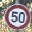

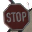

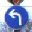

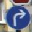

(3, 32, 32)


In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# define a small utility function to first display, then prepare the
# images for classification
def prepare_gtsrb(img):
    # make sure the image is the size expected by the network
    img = img.resize((32, 32))
    display(img)
    # convert to numpy array
    img = np.asarray(img)
    # we need the data layout to be (channels, rows, columns)
    # but it comes in (rows, columns, channels) format, so we
    # need to transpose the axes:
    img = img.transpose((2, 0, 1))
    # finally, our network is trained with BGR instead of RGB images,
    # so we need to invert the order of channels in the channel axis:
    img = img[::-1, :, :]
    return img

# load test images and prepare them
img_50 = prepare_gtsrb(Image.open("gtsrb_images/50.jpg"))
img_stop = prepare_gtsrb(Image.open("gtsrb_images/stop.jpg"))
img_left = prepare_gtsrb(Image.open("gtsrb_images/left.jpg"))
img_right = prepare_gtsrb(Image.open("gtsrb_images/right.jpg"))

# print the shape of one of the images to make sure it's correct
print(img_50.shape)

Notice how we did some preprocessing inside the prepare_gtsrb function -- resizing the images to be the correct size expected by the network, converting and transposing to a numpy array, then flipping the color axis to be ordered as BGR instead of RGB. Why did we have to do this last part? This is all about assumptions:

1. The layer implementations we have in Python assume that color images have the color (channel) dimension as the first dimension, so this is why we need to transpose.
2. This particular network is trained with the assumption that the order of color channels is blue-green-red, but the loaded images use red-green-blue ordering, so this is why we need to flip the order of elements in the color axis.

But besides this little change in how we loaded the images, loading the network itself will be exactly as before:

In [18]:
from QNN.layers import *
import pickle

# load the QNN
qnn = pickle.load(open("gtsrb-w1a1.pickle", "rb"))
qnn

OK, let's give it a whirl and see if it works! This particular network can recognize 43 different traffic signs, and (just as the previous networks) will indicate its prediction as the largest-valued element of a 43-dimensional vector. But how do we know which class corresponds to which vector index? That information comes from the GTSRB dataset itself.

In [19]:
gtsrb_classes = ['20 Km/h', '30 Km/h', '50 Km/h', '60 Km/h', '70 Km/h', '80 Km/h', 'End 80 Km/h', '100 Km/h', '120 Km/h', 'No overtaking', 'No overtaking for large trucks', 'Priority crossroad', 'Priority road', 'Give way', 'Stop', 'No vehicles', 'Prohibited for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses', 'No entry for vehicular traffic', 'Danger Ahead', 'Bend to left', 'Bend to right', 'Double bend (first to left)', 'Uneven road', 'Road slippery when wet or dirty', 'Road narrows (right)', 'Road works', 'Traffic signals', 'Pedestrians in road ahead', 'Children crossing ahead', 'Bicycles prohibited', 'Risk of snow or ice', 'Wild animals', 'End of all speed and overtaking restrictions', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Ahead or right only', 'Ahead or left only', 'Pass by on right', 'Pass by on left', 'Roundabout', 'End of no-overtaking zone', 'End of no-overtaking zone for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses']

def gtsrb_predict(img):
    # get the predictions array
    res = predict(qnn, img)
    # return the index of the largest prediction, then use the
    # classes array to map to a human-readable string
    winner_ind = np.argmax(res)
    winner_class = gtsrb_classes[winner_ind]
    # the sum of the output values add up to 1 due to softmax,
    # so we can interpret them as probabilities
    winner_prob = 100 * res[winner_ind]
    print("The QNN predicts this is a %s sign with %f percent probability" % (winner_class, winner_prob))

gtsrb_predict(img_50)
gtsrb_predict(img_stop)
gtsrb_predict(img_left)
gtsrb_predict(img_right)

The QNN predicts this is a 50 Km/h sign with 96.196610 percent probability
The QNN predicts this is a Stop sign with 99.978381 percent probability
The QNN predicts this is a Turn left ahead sign with 99.998236 percent probability
The QNN predicts this is a Turn right ahead sign with 99.953973 percent probability


Looks like it works fine! We'll now have a look at what's going inside, so let's get our showSrc function ready again.

In [20]:
import inspect

def showSrc(what):
    print("".join(inspect.getsourcelines(what)[0]))

## The Sliding Window Operator

Before we start looking into how convolutional and pooling layers work, we will describe the *sliding window* operation. This operation is a key part of both convolutional and pooling layers, and its key principle is actually quite simple: it extracts a group of elements located next to each other from an array, then goes on to the next group of elements. The two key parameters for this operator are *window size*, which is how many elements there are in each window, and *stride*, which is how many elements the window moves at every step.

The easiest way to exemplify it is on a 1D array:


In [21]:
def slidingwindow_1D(in_array, window_size, stride):
    return [in_array[i:i+window_size] for i in range(0, len(in_array)-window_size+1, stride)]

my_source_array = [-3, -2, 1, 2, 3, 4]
print("Source array: ")
print(my_source_array)
print("Sliding window with window size 2 and stride 1: ")
print(slidingwindow_1D(my_source_array, 2, 1))
print("Sliding window with window size 3 and stride 1: ")
print(slidingwindow_1D(my_source_array, 3, 1))
print("Sliding window with window size 2 and stride 2: ")
print(slidingwindow_1D(my_source_array, 2, 2))


Source array: 
[-3, -2, 1, 2, 3, 4]
Sliding window with window size 2 and stride 1: 
[[-3, -2], [-2, 1], [1, 2], [2, 3], [3, 4]]
Sliding window with window size 3 and stride 1: 
[[-3, -2, 1], [-2, 1, 2], [1, 2, 3], [2, 3, 4]]
Sliding window with window size 2 and stride 2: 
[[-3, -2], [1, 2], [3, 4]]


This can be generalized to two-, three- or n-dimensional arrays as well, and the window could potentially have a different size and stride along each dimension, but we'll stick to square windows and equal strides for now. 

For QNN convolutional and pooling layers, we will be using a premade function called **im2col**. This function operates on a multichannel (say, RGB) image, extracts image patches with a sliding window operator, and puts the results into a matrix. Let's first try it on a single-channel image:

In [22]:
import numpy as np
from QNN.im2col import im2col_indices
# a single-channel image
singlechan_img = [[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]]
# reshape as a 4D numpy array: (batchsize=1, channels=1, rows=3, cols=3)
singlechan_img = np.asarray(singlechan_img).reshape((1, 1, 3, 3))
# extract 2x2 regions with stride 1
im2col_indices(singlechan_img, field_height=2, field_width=2, padding=0, stride_y=1, stride_x=1)

array([[1, 2, 4, 5],
       [2, 3, 5, 6],
       [4, 5, 7, 8],
       [5, 6, 8, 9]])

Here you can see that each position of the window extracts a patch of the image, and puts that patch into a column of the matrix. For instance, the first window contains [[1, 2], [4, 5]] which is flattened into the first column [1, 2, 4, 5]. Then the window is moved one element to the right, and [[2, 3], [5, 6]] is extracted, and so on.

What about multi-channel images? Let's define a two-channel image this time, with the second channel only containing negative values so we can easily tell them apart.

In [23]:
# a two-channel image
twochan_img = [[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
],[
    [-1, -2, -3],
    [-4, -5, -6],
    [-7, -8, -9]
]]
# reshape as a 4D numpy array: (batchsize=1, channels=2, rows=3, cols=3)
twochan_img = np.asarray(twochan_img).reshape((1, 2, 3, 3))
# extract 2x2 regions with stride 1
im2col_indices(twochan_img, field_height=2, field_width=2, padding=0, stride_y=1, stride_x=1)

array([[ 1,  2,  4,  5],
       [ 2,  3,  5,  6],
       [ 4,  5,  7,  8],
       [ 5,  6,  8,  9],
       [-1, -2, -4, -5],
       [-2, -3, -5, -6],
       [-4, -5, -7, -8],
       [-5, -6, -8, -9]])

Here we can see that each column first contains the patch from the first channel, then the patch from the second channel. That's it for the sliding window operator! Now we can move on to how this is actually used inside the new layers.

## Pooling Layers

As you may recall, we have *activations* that are passed between the different layers of the neural network. Pooling layers are a way of making activations smaller (fewer elements) by focusing on the "important features" of the data before passing it onto the next layer, thus resulting in much less compute. Pooling is essentially a sliding window operation followed by a *reduction function*, a function that generates a single output from multiple input elements. The most common form of pooling is *max pooling*, which just extracts the maximum-valued element from each window, as shown in this image from the Stanford CS231n course notes:

![Max Pool](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

Let's have a peek at how this is implemented in the QNNPoolingLayer class:

In [24]:
showSrc(QNNPoolingLayer)

class QNNPoolingLayer(QNNLayer):
    "Perform either max or average pooling."
    def __init__(self, inDim, inChans, poolSize, strideSize, poolFxn = "MAX"):
        self.idim = inDim
        self.chans = inChans
        self.k = poolSize
        self.s = strideSize
        self.odim = ((self.idim - self.k) / self.s) + 1
        self.poolFxn = poolFxn

    def execute(self, v):
        img = v.reshape((self.chans, self.idim, self.idim))
        out_img = np.zeros((self.chans, self.odim*self.odim), dtype=np.float32)
        for c in range(self.chans):
            chan_img = img[c].reshape((1, 1, self.idim, self.idim))
            # extract parts of image with sliding window
            wnd = im2col_indices(chan_img, self.k, self.k, padding=0,
            stride_y=self.s, stride_x=self.s)
            # each window is a column -- get the reduction along columns
            if self.poolFxn == "MAX":
                out_img[c]=wnd.max(axis = 0).flatten()
            elif self.poolFxn == "AVE

Here we can see that it is indeed just the sliding window operation followed by either maximum or averaging. One important thing to note here is that each channel is pooled within itself, e.g. we do not compare pixels *between* channel 0 and channel 1 to pick up the maximum when doing max pooling.

In [25]:
before_pool = predict(qnn[:2], img_50)
after_pool = predict(qnn[:3], img_50)
print("Pooling layer window size is %d, stride is %d, pooling function is %s" % (qnn[2].k, qnn[2].s, qnn[2].poolFxn))
print("Pooling operates on %d channels, input dimension %d, output dimension %d" % (qnn[2].chans, qnn[2].idim, qnn[2].odim))
print("Activation elements before pooling: " + str(before_pool.shape))
print("Activation elements after pooling: " + str(after_pool.shape))

Pooling layer window size is 2, stride is 2, pooling function is MAX
Pooling operates on 20 channels, input dimension 28, output dimension 14
Activation elements before pooling: (15680,)
Activation elements after pooling: (3920,)


So we can see that the number of activation elements went down by 4x (2x along each axis). You may be wondering what happened to activations being images? The vectors we obtained are 1D vectors, and there is no channel/rows/columns information visible in the shape. This is an assumption about how data is to be passed between layers in this implementation -- all passed arrays are supposed to be flat. We can actually see how the **QNNPoolingLayer** actually reshapes the input activations into images in the first line of **QNNPoolingLayer.execute**. We can do the same manually to examine what the pre- and post-pooling activations looke like.

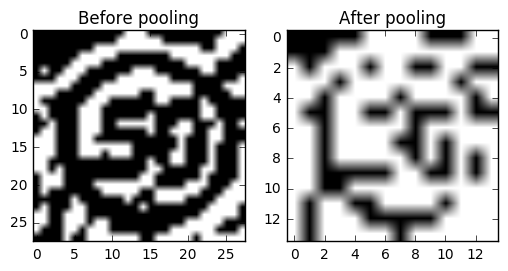

In [26]:
import matplotlib.pyplot as plt

# reshape activations as images
before_pool = before_pool.reshape((20, 28, 28))
after_pool = after_pool.reshape((20, 14, 14))
# display the 3rd channel
% matplotlib inline
fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(before_pool[2], cmap='gray')
a.set_title('Before pooling')

a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(after_pool[2], cmap='gray')
imgplot.set_clim(0.0,0.7)
a.set_title('After pooling')

You can actually still see the circular border and 50 in the pre-pooling activations. It is also worth mentioning that since the network we are looking at is still a binarized one, the activations are also still only -1 and +1s. We can see that our network contains a layer pattern in the first part -- a convolution, bipolar thresholding, pooling combination that repeats twice.

> **Aside: OR maxpooling for binarized networks.** For QNNs using binary activations with a 0-bit encoding a -1 and a 1-bit encoding a +1, the max pooling reduction can be simply performed by taking the binary OR of all bits in the window.

In [27]:
print(after_pool[3])
print(qnn[:6])

[[-1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.]
 [-1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.]
 [-1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.]]
[<QNN.layers.QNNConvolutionLayer object at 0x7f9e127c6910>, <QNN.layers.QNNBipolarThresholdingLayer object at 0x7f9e00f41e50>, <QNN.layers.QNNPoolingLayer object at 0x7f9e00

## Convolutional Layers

Now that we have covered what the pooling layers do, and since we already know what the thresholding layers do from the previous section, we can examine how the convolutions work. Althrough there are more "direct" ways of implementing a convolutional layer, we will focus on the so-called "convolution lowering" approach here, which is just a sliding window operation followed by matrix-matrix multiplication. This is somewhat similar to the fully-connected layers from the previous sections, with two key differences:

1. The input activations in convolutional layers are first passed through a sliding window operator, as opposed to multiplying directly as a vector in fully-connected layers.
2. The operation in convolutional layers is a matrix-matrix multiply, as opposed to matrix-vector multiply in fully-connected layers.

To see that this is indeed the case, let's have a look at how **QNNConvolutionLayer** is implemented.

In [28]:
showSrc(QNNConvolutionLayer)

class QNNConvolutionLayer(QNNLayer):
    "Convolution via im2col and matrix-matrix multiplication"
    def __init__(self, W, inDim, pad, stride, padVal=0):
        self.ofm = W.shape[0] # number of output channels
        self.ifm = W.shape[1] # number of input channels
        self.k = W.shape[2]   # kernel (window) dimension
        self.idim = inDim     # input image dimension
        self.padded_idim = inDim + 2*pad  # input image dimension including padding
        self.odim = ((self.padded_idim - self.k) / stride) + 1  # output image dimension
        self.stride = stride  # stride for sliding window
        self.pad = pad        # number of padding pixels to add on each edge
        self.padVal = padVal  # value of padding pixels
        if(W.shape[2] != W.shape[3]):
            raise Exception("Only square conv filters supported for now")
        # instantiate internal layer components
        self.layers = []
        # add a padding layer, if padding is required
        if pad

There's a bit of unusual stuff going on in the constructor, so let's go over that first. Namely, besides the computation to determine the size of the outputs, this layer can actually contain another (potentially two) layers: **QNNPaddingLayer** and **QNNSlidingWindowLayer**. In the **execute()** call you can see that the input is first passed through these layers before performing the matrix multiply, so let's start by looking at what happens inside a **QNNPaddingLayer**.

In [29]:
showSrc(QNNPaddingLayer)

class QNNPaddingLayer(QNNLayer):
    "A layer that adds padding around the edges of the image."
    def __init__(self, inDim, inChans, padCount, padVal):
        self.dim = inDim          # input image dimension
        self.chans = inChans      # number of input channels
        self.padCount = padCount  # number of pixels to add on each edge
        self.padVal = padVal      # value of pixels to be added to each edge

    def execute(self, v):
        img = v.reshape((self.chans, self.dim, self.dim))
        padCounts = ((0, 0),
                     (self.padCount, self.padCount),
                     (self.padCount, self.padCount))
        img = np.pad(img, padCounts, "constant", constant_values=self.padVal)
        return img.flatten()



So what the padding layer does is to add padding pixels to the edges of the image. Padding is actually not used in our example network, but is commonly used to increase the accuracy via less information loss on border pixels. 

> **Aside: Padding in binarized networks.** Zero is almost universally used as the padding value, but what if we have binarized activations that can only represent -1 and +1? It turns out that it works just fine to train networks that use -1 as the padding value, as reported in [this article](https://arxiv.org/pdf/1701.03400.pdf).

We can set up a toy example to see what padding looks like in practice.

In [30]:
toy_padding_layer = QNNPaddingLayer(3, 1, 1, 0)
toy_padding_in = np.asarray([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
print("Before padding:")
print(toy_padding_in)
toy_padding_out = toy_padding_layer.execute(toy_padding_in.flatten())
print("After padding:")
print(toy_padding_out.reshape(5, 5))

Before padding:
[[1 2 3]
 [4 5 6]
 [7 8 9]]
After padding:
[[0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]
 [0 0 0 0 0]]


What about **QNNSlidingWindowLayer**? You guessed right -- it just calls the sliding window operator (im2col).

In [31]:
showSrc(QNNSlidingWindowLayer)

class QNNSlidingWindowLayer(QNNLayer):
    "Slide a window over a multichannel image (im2col)"
    def __init__(self, inDim, inChans, windowDim, stride=1):
        self.idim = inDim     # input image dimension
        self.chans = inChans  # channels in input image
        self.k = windowDim    # window size
        self.s = stride       # stride for next window

    def execute(self, v):
        # reshape the input vector into a 2D image
        img = v.reshape((1, self.chans, self.idim, self.idim))
        # call im2col to get the sliding window result
        res = im2col_indices(img, self.k, self.k, padding=0,
                            stride_y=self.s, stride_x=self.s)
        return res.flatten()



That's about it for convolutional layers. Although the procedure itself is straightforward, understanding all the details involved in what data goes where, and gets multiplied with what, can take a bit of time. To help you better understand this, here is a figure illustrating what a lowered convolution looks like, taken from [this article](https://arxiv.org/pdf/1410.0759.pdf):
![Convolution lowering](conv-lowering-chetlur.png)

Some extra pointers to help you better understand what this image is trying to describe:
* The input activation (labeled "Image Data") is a three-channel (represented by red, green, blue) image
* A 2x2 sliding window is used to create the image matrix on the top right.
* The image matrix has (k * k * input channels) rows and (number of output pixels) columns.
* The "filter data" comes from the neural network training. Each filter has the same size as the sliding window (2x2).
* A different filter connects each output channel to each input channel. There are 3 input channels and 2 output channels here, so there are 6 different filters. Results for the filters that correspond to the same output channels are summed together (i.e. those values are in the same row of the matrix). Here, all the F filters are used to compute the first output channel, and all the G filters are used to compute the second output channel.
* The filters are "flattened" together to create the weight matrix on the lower left. The weight matrix has one row per output channel, and (k * k * input channels) columns.
* The output matrix (the yellow matrix on the bottom right) is obtained by multiplying the weight matrix with the image matrix. It has one row per output channel, and (number of output pixels) columns.